# Use Case 3: Associating Clinical Variables with Acetylation

For this use case we wanted to show how to analyze the acetylation data with a clinical variable. In this use case we will use the histologic type clinical variable, but the processes shown here can be applied across many others. Our purpose is to identify which acetylation sites differ significantly in frequency between non-tumor, serous and endometrial cells.

# Step 1: Import necessary packages

This use case will guide you through an example in using the acetylation data included in our package.
We will start by importing the endometrial data, along with the tools that we need to analyze it.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import CPTAC.Endometrial as en
import math

Welcome to the CPTAC data service package. Available datasets may be
viewed using CPTAC.list_data(). In order to access a specific data
set, import a CPTAC subfolder using either 'import CPTAC.Dataset' or
'from CPTAC import Dataset'.
******
Version: 0.3.1
******
Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Acetylation Proteomics Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


In [2]:
#Get acetylation data
acetyl = en.get_acetylproteomics()

In [3]:
#Show a list of clinical attributes that can be tested with acetylation data
list(en.get_clinical().columns)

['Proteomics_Participant_ID',
 'Proteomics_Tumor_Normal',
 'Country',
 'Histologic_Grade_FIGO',
 'Myometrial_invasion_Specify',
 'Histologic_type',
 'Treatment_naive',
 'Tumor_purity',
 'Path_Stage_Primary_Tumor-pT',
 'Path_Stage_Reg_Lymph_Nodes-pN',
 'Clin_Stage_Dist_Mets-cM',
 'Path_Stage_Dist_Mets-pM',
 'tumor_Stage-Pathological',
 'FIGO_stage',
 'LVSI',
 'BMI',
 'Age',
 'Diabetes',
 'Race',
 'Ethnicity',
 'Gender',
 'Tumor_Site',
 'Tumor_Site_Other',
 'Tumor_Focality',
 'Tumor_Size_cm',
 'Num_full_term_pregnancies']

# Step 2: Choose Clinical Attribute and Merge Dataframe

For this use case, we will use the 'Histologic_type' clinical attribute in order to find differences in acetylation sites between "endometrioid" and "serous" cancer cells.

In [4]:
#Set desired attribute to variable 'clinical_attribute'
clinical_attribute = "Histologic_type"
clinical = en.get_clinical()

Here we will merge our desired clinical attribute with our acetylation dataframe using "en.compare"

In [5]:
#Merge attribute with acetylation dataframe
clinical_and_acetylation = en.append_metadata_to_omics(metadata_df=clinical, omics_df=acetyl, metadata_cols=clinical_attribute)
clinical_and_acetylation.head()

,Histologic_type,A2M-K1168_acetylproteomics,A2M-K1176_acetylproteomics,A2M-K135_acetylproteomics,A2M-K145_acetylproteomics,A2M-K516_acetylproteomics,A2M-K664_acetylproteomics,A2M-K682_acetylproteomics,AACS-K391_acetylproteomics,AAGAB-K290_acetylproteomics,...,ZSCAN31-K215_acetylproteomics,ZSCAN32-K659_acetylproteomics,ZW10-K634_acetylproteomics,ZYX-K24_acetylproteomics,ZYX-K25_acetylproteomics,ZYX-K265_acetylproteomics,ZYX-K272_acetylproteomics,ZYX-K279_acetylproteomics,ZYX-K533_acetylproteomics,ZZZ3-K117_acetylproteomics
idx,,,,,,,,,,,,,,,,,,,,,
S001,Endometrioid,NaN,1.080,NaN,NaN,NaN,NaN,NaN,NaN,0.461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S002,Endometrioid,NaN,0.477,NaN,NaN,NaN,NaN,NaN,NaN,1.770,...,-0.104,-0.80300,NaN,-0.988,-0.343,-0.307,NaN,-0.0955,NaN,NaN
S003,Endometrioid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.815,...,NaN,NaN,NaN,-0.459,-1.170,NaN,NaN,-0.7050,0.089,NaN
S005,Endometrioid,NaN,-0.608,NaN,NaN,-0.919,NaN,NaN,NaN,NaN,...,-0.457,-0.00175,-0.33,NaN,-0.537,NaN,NaN,-0.3700,NaN,NaN
S006,Serous,NaN,1.630,NaN,2.4,NaN,NaN,1.26,NaN,0.205,...,NaN,0.41100,NaN,NaN,-0.358,NaN,NaN,-0.9700,NaN,NaN


# Step 3: Make Different Dataframes and Establish Threshold

In [6]:
#Show possible variations of Histologic_type
clinical_and_acetylation[clinical_attribute].unique()

array(['Endometrioid', 'Serous', nan], dtype=object)

In this step, we will make two different dataframes for "Endometrioid" and "Serous" cancer types, as well as fill the NaN columns with "Non-Tumor."

In [7]:
#Make dataframes with only endometrioid and only serous data in order to compare 
endom = clinical_and_acetylation.loc[clinical_and_acetylation[clinical_attribute] == "Endometrioid"]
serous = clinical_and_acetylation.loc[clinical_and_acetylation[clinical_attribute] == "Serous"]
#Here is where we set the NaN values to "Non_Tumor"
clinical_and_acetylation[[clinical_attribute]] = clinical_and_acetylation[[clinical_attribute]].fillna(value="Non_Tumor")

Now that we have our different dataframes, we want to make sure that the amount of data we are using for each site is significant. Since there are fewer patients with "serous" tumors than with "endometrioid," we will check to make sure that we have at least five values for each acetylation site that we are comparing that have a measurement of intensity for serous patients.

In [8]:
num_sites_sufficient_data = 0
for num in range(1,len(serous.columns)):
    site = serous.columns[num]
    oneSite = serous[site]
    num_datapoints = oneSite.count() #Here we count the number of datapoints that we have at each site
    if num_datapoints >= 5:
        num_sites_sufficient_data += 1
print("Number of sites with sufficient data: ", num_sites_sufficient_data)
threshold = .05 / num_sites_sufficient_data
print("Multiple hypothesis adjusted threshold: ", threshold)

Number of sites with sufficient data:  3936
Multiple hypothesis adjusted threshold:  1.2703252032520325e-05


# Step 4: Compare Endometrioid and Serous Values

Now that we have a calculated threshold value, we will loop through the data and compare endometrioid versus serous data for each acetylation site. If we find a site that is significantly different, we will add it to a list.

In [9]:
significantTests = []
significantSites = []
sigSiteCount = 0
p_value_index = 1
np.warnings.filterwarnings('ignore')
for num in range(1,len(clinical_and_acetylation.columns)):
    site = clinical_and_acetylation.columns[num]
    ttestRes = scipy.stats.ttest_ind(endom[site], serous[site])#This returns a tuple, with the t-statistic as 
    #the first value and the p-value as the second(index 1). We are interested in the p-value.
    if (ttestRes[p_value_index] <= threshold): #Check if there is a significant enough difference between data points
        sigSiteCount += 1
        significantTests.append(ttestRes)
        significantSites.append(site)
print("Number of sites with statistically significant difference between endometrioid and serous values: " + str(sigSiteCount))

Number of sites with statistically significant difference between endometrioid and serous values: 8


In [10]:
print(significantSites)

['FOXA2-K280_acetylproteomics', 'FUS-K332_acetylproteomics', 'JADE3-K32_acetylproteomics', 'MCRS1-K136_acetylproteomics', 'MEAF6-K69_acetylproteomics', 'NCL-K398_acetylproteomics', 'SUPT16H-K674_acetylproteomics', 'TBL1XR1-K102_acetylproteomics']


# Step 5: Graph Results

Now that we have a list of eight acetylation sites that differ between endometrioid and serous intensities, we will graph them using a boxplot and a stripplot in order to visually see the difference, as well as compare it with normal cells.

Ttest_indResult(statistic=5.991702127182772, pvalue=3.89570439448459e-08)


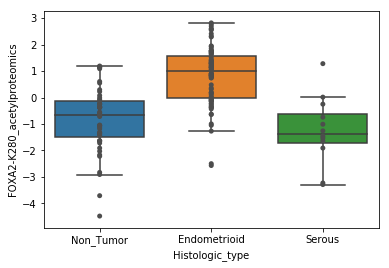

In [11]:
graphingSite = 'FOXA2-K280_acetylproteomics'
print(scipy.stats.ttest_ind(endom[graphingSite], serous[graphingSite]))
sns.boxplot(x=clinical_attribute, y=graphingSite, data = clinical_and_acetylation, showfliers = False, order = ["Non_Tumor", "Endometrioid", "Serous"])
sns.stripplot(x=clinical_attribute, y=graphingSite, data = clinical_and_acetylation, color = '.3', order = ["Non_Tumor", "Endometrioid", "Serous"])
#color = '.3' makes the dots black

Ttest_indResult(statistic=-4.69713782197463, pvalue=9.090116393624886e-06)


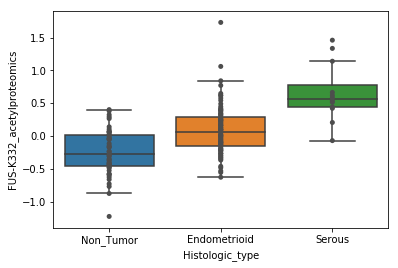

In [12]:
graphingSite = 'FUS-K332_acetylproteomics'
print(scipy.stats.ttest_ind(endom[graphingSite], serous[graphingSite]))
sns.boxplot(x=clinical_attribute, y=graphingSite, data = clinical_and_acetylation, showfliers = False, order = ["Non_Tumor", "Endometrioid", "Serous"])
sns.stripplot(x=clinical_attribute, y=graphingSite, data = clinical_and_acetylation, color = '.3', order = ["Non_Tumor", "Endometrioid", "Serous"])

Ttest_indResult(statistic=-5.264353282778082, pvalue=9.009261990390327e-07)


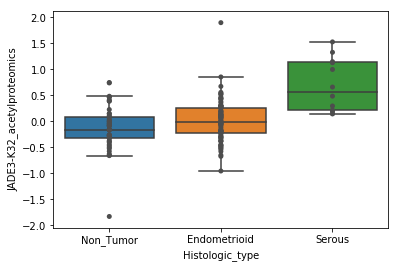

In [13]:
graphingSite = 'JADE3-K32_acetylproteomics'
print(scipy.stats.ttest_ind(endom[graphingSite], serous[graphingSite]))
sns.boxplot(x=clinical_attribute, y=graphingSite, data = clinical_and_acetylation, showfliers = False, order = ["Non_Tumor", "Endometrioid", "Serous"])
sns.stripplot(x=clinical_attribute, y=graphingSite, data = clinical_and_acetylation, color = '.3', order = ["Non_Tumor", "Endometrioid", "Serous"])

Ttest_indResult(statistic=-4.905999919645725, pvalue=3.94259188205917e-06)


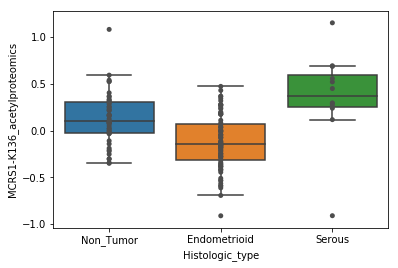

In [14]:
graphingSite = 'MCRS1-K136_acetylproteomics'
print(scipy.stats.ttest_ind(endom[graphingSite], serous[graphingSite]))
sns.boxplot(x=clinical_attribute, y=graphingSite, data = clinical_and_acetylation, showfliers = False, order = ["Non_Tumor", "Endometrioid", "Serous"])
sns.stripplot(x=clinical_attribute, y=graphingSite, data = clinical_and_acetylation, color = '.3', order = ["Non_Tumor", "Endometrioid", "Serous"])

Ttest_indResult(statistic=-5.3886215048866974, pvalue=5.336611006090782e-07)


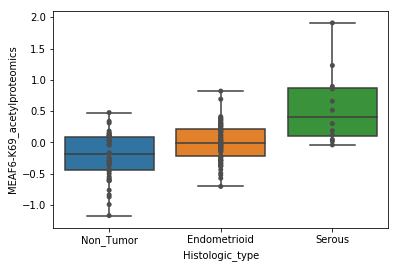

In [15]:
graphingSite = 'MEAF6-K69_acetylproteomics'
print(scipy.stats.ttest_ind(endom[graphingSite], serous[graphingSite]))
sns.boxplot(x=clinical_attribute, y=graphingSite, data = clinical_and_acetylation, showfliers = False, order = ["Non_Tumor", "Endometrioid", "Serous"])
sns.stripplot(x=clinical_attribute, y=graphingSite, data = clinical_and_acetylation, color = '.3', order = ["Non_Tumor", "Endometrioid", "Serous"])

Ttest_indResult(statistic=-5.517844309062241, pvalue=3.0773084577689524e-07)


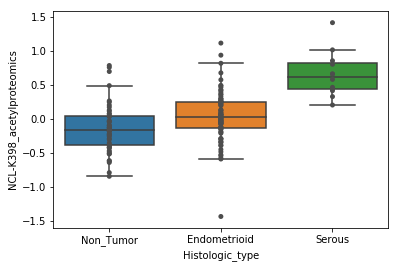

In [16]:
graphingSite = 'NCL-K398_acetylproteomics'
print(scipy.stats.ttest_ind(endom[graphingSite], serous[graphingSite]))
sns.boxplot(x=clinical_attribute, y=graphingSite, data = clinical_and_acetylation, showfliers = False, order = ["Non_Tumor", "Endometrioid", "Serous"])
sns.stripplot(x=clinical_attribute, y=graphingSite, data = clinical_and_acetylation, color = '.3', order = ["Non_Tumor", "Endometrioid", "Serous"])

Ttest_indResult(statistic=-4.690071539871116, pvalue=9.34749100983442e-06)


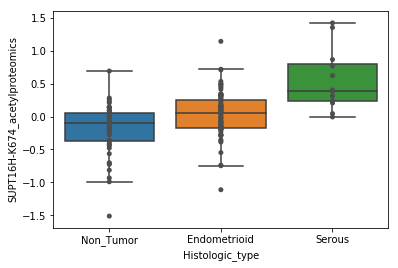

In [17]:
graphingSite = 'SUPT16H-K674_acetylproteomics'
print(scipy.stats.ttest_ind(endom[graphingSite], serous[graphingSite]))
sns.boxplot(x=clinical_attribute, y=graphingSite, data = clinical_and_acetylation, showfliers = False, order = ["Non_Tumor", "Endometrioid", "Serous"])
sns.stripplot(x=clinical_attribute, y=graphingSite, data = clinical_and_acetylation, color = '.3', order = ["Non_Tumor", "Endometrioid", "Serous"])

Ttest_indResult(statistic=-6.058405376720225, pvalue=2.8961545616585784e-08)


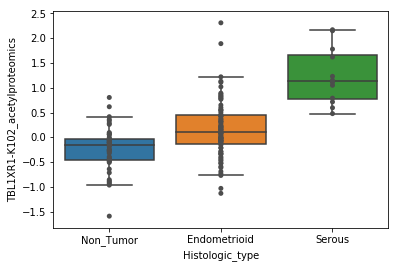

In [18]:
graphingSite = 'TBL1XR1-K102_acetylproteomics'
print(scipy.stats.ttest_ind(endom[graphingSite], serous[graphingSite]))
sns.boxplot(x=clinical_attribute, y=graphingSite, data = clinical_and_acetylation, showfliers = False, order = ["Non_Tumor", "Endometrioid", "Serous"])
sns.stripplot(x=clinical_attribute, y=graphingSite, data = clinical_and_acetylation, color = '.3', order = ["Non_Tumor", "Endometrioid", "Serous"])